In [4]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns


In [5]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,10)

---

In [43]:
def api_url(indikator_: int) -> str:
    """ Return URL for endpoint at specified indikator id """
    url = 'http://193.246.68.117:8080/gp/GP?type=EXPORT&indikatoren={}&raumtyp=1&text=yes'
    return url.format(indikator_)

In [44]:
def api_get_dataframe(indikator_: int) -> (pd.DataFrame, pd.DataFrame):
    """ Generate pd.DataFrames for 'RAUM' and 'INDIKATOR' keys using indikator id """
    json_ = requests.get(api_url(indikator_)).json()
    return (pd.io.json.json_normalize(json_['RAUM']),
            pd.io.json.json_normalize(json_['INDIKATOR']))

In [51]:
def gemeinde_dataframe(raum_df_: pd.DataFrame) -> pd.DataFrame:
    """ Generate pd.DataFrame using pd.DataFrame of 'RAUM' data - index is gemeinde name """
    raum_dates = raum_df_.drop(['BFS', 'DATEN_VORHANDEN', 'ALLE_JAHRE', 'RAUMEINHEIT_ID', 'RAUMEINHEIT_NAME'], axis=1).astype(float)
    raum_dates.columns = sorted(raum_df_.ALLE_JAHRE[0])
    raum_dates.index = raum_df_.RAUMEINHEIT_NAME
    return raum_dates

In [52]:
def gemeinde_by_date(raum_df_: pd.DataFrame, gemeinde: str) -> pd.DataFrame:
    """ Generate single column pd.DataFrame using pd.DataFrame of 'RAUM' data - index is date """
    df = raum_df_[raum_df_.RAUMEINHEIT_NAME == gemeinde]
    ix = df.index[0]
    years = sorted(df.ALLE_JAHRE.values[0])
    df = df.drop(['BFS', 'DATEN_VORHANDEN', 'ALLE_JAHRE', 'RAUMEINHEIT_ID','RAUMEINHEIT_NAME'], axis=1).astype(float)
    df.columns = years
    return pd.DataFrame(df.stack()[ix], columns=[gemeinde])

In [56]:
def gemeinde_df_by_indikator(indikator_: int) -> pd.DataFrame:
    return gemeinde_dataframe(api_get_dataframe(indikator_)[0])

---

In [45]:
bevolkerung, _ = api_get_dataframe(133)

In [50]:
gemeinde_dataframe(bevolkerung).head()

,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
RAUMEINHEIT_NAME,,,,,,,,,,,,,,,,,,,,,
Adlikon,400.0,400.0,389.0,388.0,390.0,394.0,398.0,394.0,380.0,398.0,...,571.0,579.0,577.0,579.0,562.0,573.0,609.0,662.0,662.0,655.0
Adliswil,10422.0,11349.0,11760.0,12450.0,12898.0,13723.0,14738.0,15362.0,15920.0,15901.0,...,15918.0,16051.0,16488.0,17472.0,17997.0,18216.0,18381.0,18551.0,18651.0,18731.0
Aesch ZH,340.0,340.0,349.0,362.0,401.0,422.0,436.0,459.0,472.0,469.0,...,987.0,1001.0,1034.0,1083.0,1158.0,1183.0,1182.0,1198.0,1269.0,1341.0
Aeugst a.A.,710.0,720.0,705.0,695.0,745.0,704.0,678.0,726.0,700.0,729.0,...,1700.0,1737.0,1822.0,1911.0,1959.0,1970.0,1952.0,1986.0,1969.0,1934.0
Affoltern a.A.,5370.0,5753.0,6001.0,6303.0,6539.0,6660.0,6945.0,6997.0,7363.0,7325.0,...,10631.0,10705.0,11063.0,11140.0,11265.0,11342.0,11540.0,11695.0,11868.0,12080.0


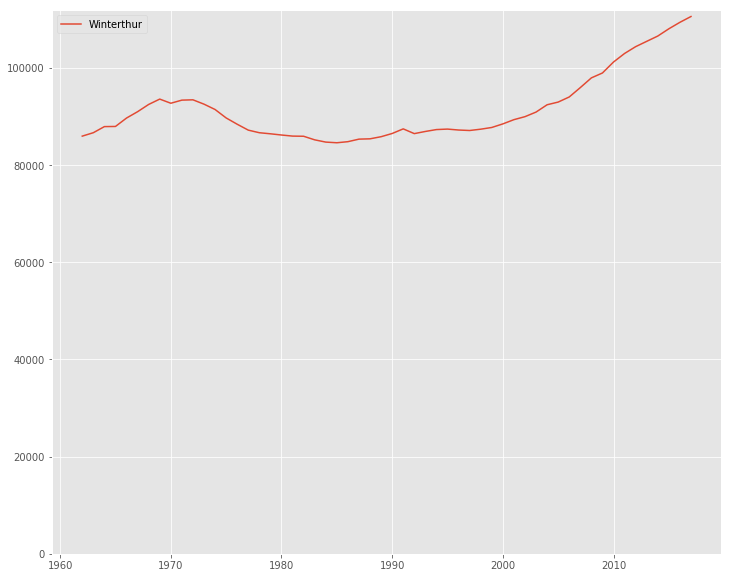

In [42]:
gemeinde_by_date(bevolkerung, 'Winterthur').plot()
plt.ylim((0, max(plt.ylim(0))))
None

In [47]:
bevolkerungzunahme, _ = api_get_dataframe(200)

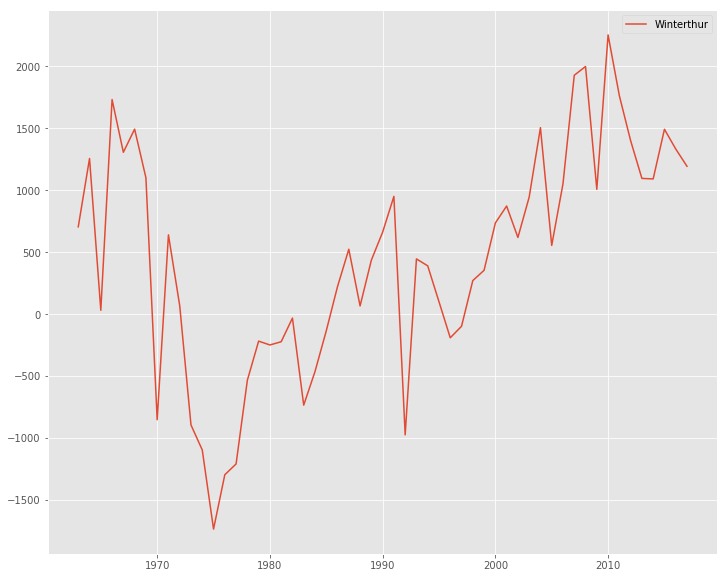

In [48]:
gemeinde_by_date(bevolkerungzunahme, 'Winterthur').plot()

In [57]:
auslanderanteil = gemeinde_df_by_indikator(205)

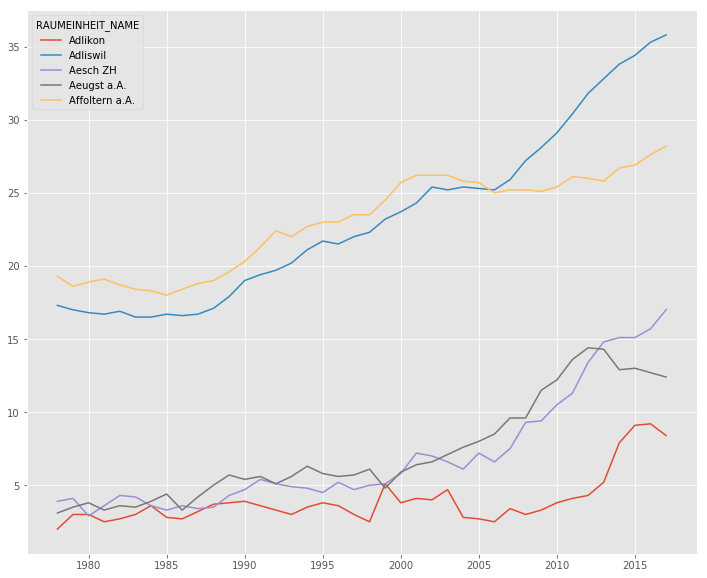

In [61]:
auslanderanteil.head().T.plot()